# EOF analysis of Spatiotemporal Dataset

**EOF analysis**: In statistics and signal processing, the method of empirical orthogonal function (EOF) analysis is a decomposition of a signal or data set in terms of orthogonal basis functions which are determined from the data. It is similar to performing a principal components analysis on the data, except that the EOF method finds both temporal projections and spatial patterns. The term is also interchangeable with the geographically weighted PCAs in geophysics (https://en.wikipedia.org/wiki/Empirical_orthogonal_functions). The spatial patterns are the EOFs and can be thought of as basis functions in terms of variance. The associated temporal projections are the principal components (PCs) and are the temporal coefficients of the EOF patterns.

Some background on EOFs can be found [here](https://projectpythia.org/eofs-cookbook/notebooks/eof-intro.html#).

**Python EOF package**: The EOF package that we will use is [xeofs](https://xeofs.readthedocs.io/en/latest/).

**This EOF example** is motivated by [Project Pythia EOFs Cookbook](https://projectpythia.org/eofs-cookbook/README.html).

We will use the [NOAA Extended Reconstructed Sea Surface Temperature (ERSST) v5](https://psl.noaa.gov/data/gridded/data.noaa.ersst.v5.html) product, a widely used and trusted gridded compilation of of historical data going back to 1854.

## 0. Create and activate eofs-cookbook-dev conda environment

### 1. Clone the `https://github.com/ProjectPythia/eofs-cookbook` repository:

In the terminal, first `cd` to your home directory. Then clone the `eofs-cookbook` repository by - 

$ git clone https://github.com/ProjectPythia/eofs-cookbook.git

### 2. Move into the `eofs-cookbook` directory:

$ cd eofs-cookbook

### 3. Create and activate your conda environment from the `environment.yml` file:

$ conda env create -f environment.yml

$ conda activate eofs-cookbook-dev

## 1. Load basic libraries

In [1]:
import numpy as np
import xarray as xr
import matplotlib.pyplot as plt
import xeofs as xe
from scipy import signal

## 2. Read SST Data

In [22]:
url = 'http://www.esrl.noaa.gov/psd/thredds/dodsC/Datasets/noaa.ersst.v5/sst.mnmean.nc'
ds = xr.open_dataset(url, drop_variables=['time_bnds'])
ds = ds.sel(time=slice('1982', '2016'))

## 3. Detrend and remove seasonal cycle 

Before carrying out EOF analysis, we need to remove the linear trend of the SST data as well as the seasonal cycle.

### 3.1 Detrend the data

Here we use the `detrend` function from [`scipy.signal`]('https://docs.scipy.org/doc/scipy/reference/generated/scipy.signal.detrend.html'). The basic syntax is `detrend(data, axis, type='linear')` with `axis` denoting the axis along which to detrend the data. However, the `detrend` function can't deal with NaNs so some additional data processing needs to be applied (see code below).

We could also use `polyfit` or `stats.linregress` to calculate the linear trend first and subtract the linear trend from the data.

In [23]:
nan_ind = np.isnan(ds.sst.values)

sstf = xr.where(np.isnan(ds.sst), 1000, ds.sst) # fill nan with 1000

sstf_detrend = signal.detrend(sstf, axis=0, type='linear') # return detrended data in ndarray

sstf_detrend[nan_ind] = np.nan

sstf_detrend = xr.DataArray(sstf_detrend, dims=['time', 'lat', 'lon'],
                           coords={'time': ds.time,
                                   'lat': ds.lat,
                                   'lon': ds.lon})

### 3.2 Calculate and remove seasonal cycle

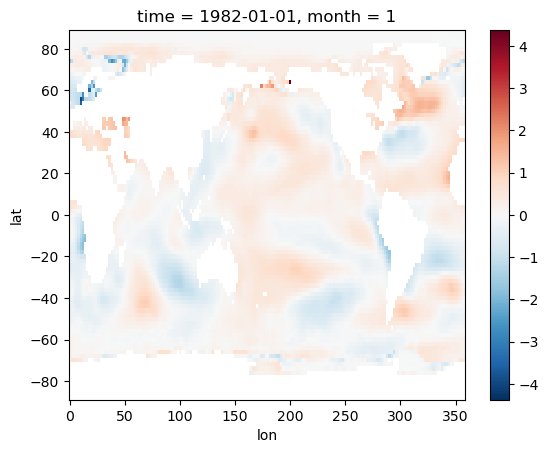

In [26]:
gb = sstf_detrend.groupby('time.month')
sst_anom = gb - gb.mean(dim='time') # use groupby to calculate the monthly climatology and anomaly
sst_anom[0,:,:].plot() # always a good idea to check immediate results

## 4. Carry out EOF analysis

### 4.1 Carry out the EOF analysis

The following EOF calculation will return EOFs, principal component time series (PCs) and fractions of the total variance accounted for by each EOF.

In [27]:
ds_model = xe.single.EOF(n_modes=4, use_coslat=True) # square-root of cosine of latitude weights are applied
ds_model.fit(sst_anom, dim='time')
ds_eofs = ds_model.components()
ds_pcs = ds_model.scores()
ds_expvar = ds_model.explained_variance_ratio()

### 4.2 Visualize the results of leading EOFs

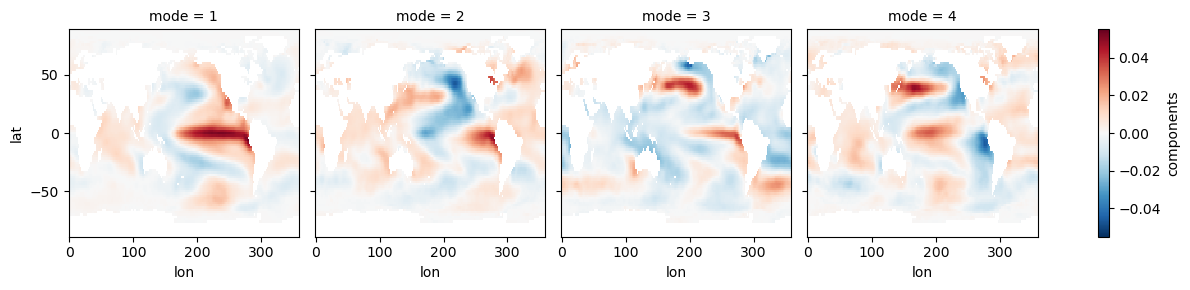

In [29]:
ds_eofs.plot(col='mode');

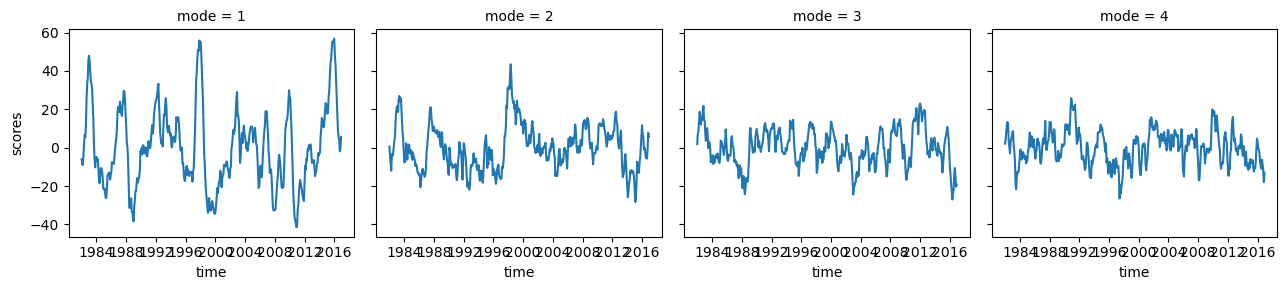

In [30]:
ds_pcs.plot(col='mode');

The spatial pattern of EOF1 is the canonical El Nino pattern, and the associated time series shows large peaks and troughs for well-known El Nino and La Nina events.

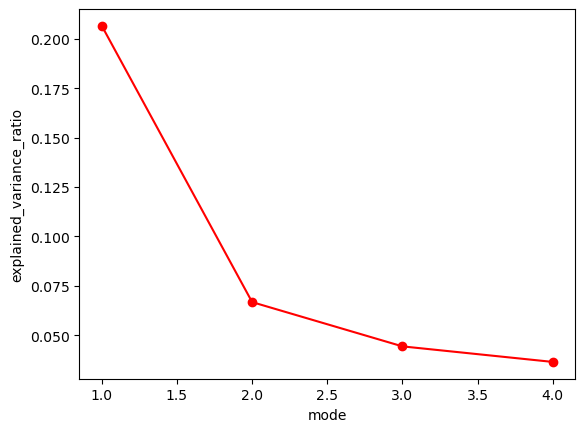

In [31]:
ds_expvar.plot(marker="o", color='r'); # check variances explained by leading EOFs

In [37]:
ds_expvar.values

array([0.2064603 , 0.06679153, 0.04441005, 0.03654955])

In total, the first 4 EOFs explain about 35% of the total variance, with the leading EOF explaining 21%.

## Useful Python Packages for Earth Sciences

Here is a nice summary - https://rcaes2023.github.io/rcaes_site/Lecture_11_Geopandas/.